In [1]:
import torch
import weakref
import cv2
import copy
import matplotlib.pyplot as plt
from torch.optim import optimizer
from engine.trainer import SimpleTrainer

from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from engine.optimizer import build_optimizer,build_lr_scheduler

from data.build import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from data.mapper import DatasetMapper
import data.transforms as T
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
from structures.image_list import ImageList
from engine.detection_checkpointer import DetectionCheckpointer
from data.utils import build_augmentation


In [2]:
print(torch.cuda.device_count())
torch.cuda.set_device(2)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('./config_files/voc.yaml')
cfg.MODEL.RPN.USE_MDN=True
cfg.log = False 
cfg.MODEL.ROI_HEADS.AUTO_LABEL = True
cfg.MODEL.ROI_HEADS.AF = 'uncertainty'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.INPUT.RANDOM_FLIP = "none"
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

4
2


In [3]:
DIR_NAME = '/data/jeongeun/OWOD_datasets/VOC2007'
split = 'train'
rcnn = GeneralizedRCNN(cfg).to('cuda')
state_dict = torch.load('./ckpt/uncertainty/mdn_17000.pt')
optim = build_optimizer(cfg,rcnn)
schedular = build_lr_scheduler(cfg,optim)
checkpointer = DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            rcnn,
            cfg.OUTPUT_DIR
        )
checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=True)
rcnn = checkpointer.model

data = load_voc_instances(DIR_NAME,split,VOC_CLASS_NAMES,'t2')
mapper = DatasetMapper(is_train=True, augmentations=build_augmentation(cfg,True))
data_loader = build_detection_train_loader(data,mapper=mapper,total_batch_size=1)
loader = iter(data_loader)


USE MDN


/data/private/faster_rcnn_rilab/model/rpn/rpn_mdn.py:42: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.weight,std=0.01)
/data/private/faster_rcnn_rilab/model/rpn/rpn_mdn.py:43: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.bias,0)
Some model parameters or buffers are not found in the checkpoint:
proposal_generator.head.anchor_deltas.{bias, weight}
proposal_generator.head.conv.{bias, weight}
proposal_generator.head.objectness.cnn_mu.{bias, weight}
proposal_generator.head.objectness.cnn_pi.{bias, weight}
proposal_generator.head.objectness.cnn_sigma.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}
  res2.0.conv1.bias
  res2.0.conv2.bias
  res2.0.conv3.bias
  res2.0.shortcut.bias
  res2.1.conv1.bias
  res2.1.conv2.bias
  res2.1.

In [47]:
batched_inputs = next(loader)


images = rcnn.preprocess_image(batched_inputs)
features = rcnn.backbone(images.tensor)
gt_instances = [x['instances'].to(rcnn.device) for x in batched_inputs]
proposals, proposal_losses = rcnn.proposal_generator(images, features, gt_instances)
# images, features, proposals, gt_instances
proposals = rcnn.roi_heads.label_and_sample_proposals(proposals, gt_instances)

In [48]:
image = batched_inputs[0]['image']
inputs = {"image": batched_inputs[0]['image'], 
            "height": batched_inputs[0]['height'], "width": batched_inputs[0]['width']}
proposals = rcnn._postprocess(proposals,[inputs],images.image_sizes)

In [49]:
gt_classes = proposals[0]['instances'].gt_classes
# gt_classes = proposals[0]._fields['gt_classes']
unkown_index = torch.where(gt_classes==20)
known = torch.where(gt_classes<20)

proposal_boxes = proposals[0]['instances'].proposal_boxes
# proposal_boxes = proposals[0]._fields['proposal_boxes'].tensor
proposal_boxes_unkown = proposal_boxes[unkown_index]
proposal_boxes_known = proposal_boxes[known]

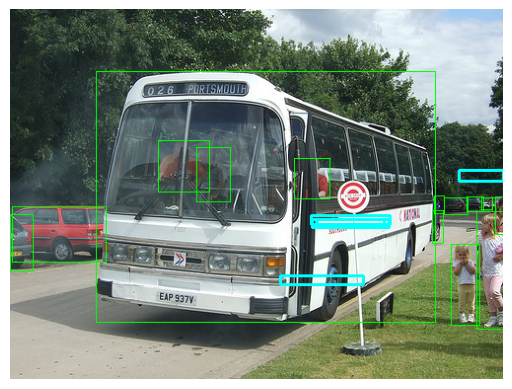

In [50]:
file_name = batched_inputs[0]['file_name']
demo_image = cv2.imread(file_name)
# demo_image = image.permute(1,2,0).numpy()
for bbox in proposal_boxes_known:
    # print(bbox)
    bbox = bbox.tolist()
    # cv2.rectangle(demo_image, (0,0), (100,100), (0, 255, 0), 2)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (0, 255, 0), 1)

for bbox in proposal_boxes_unkown:
    # print(bbox)
    bbox = bbox.tolist()
    # cv2.rectangle(demo_image, (0,0), (100,100), (0, 255, 0), 2)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (255, 255, 0), 2)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()